In [1]:
reset -fs

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
%matplotlib inline

from logger import Logger

# Preprocessing

## Truncate & Padding

Assuming that our context $\mathbf{D}$ and question $\mathbf{Q}$ are already converted from token to ids, saved in files

In [3]:
def truncate(filepath,ml=1000):
    """truncate at max length, ignore if shorter
    """
    c = []
    with open(filepath,'r') as f:
        for line in f:
            c.append([int(item) for i,item in enumerate(line.strip().split()) if i<ml])
    return c

def padding(c):   #padding
    """padding with 0 w.r.t max length 
    """
    max_l = max([len(i) for i in c])
    for i in range(len(c)):
        c[i] = c[i] + (max_l-len(c[i]))*[0]
    return c, max_l

In [4]:
# load data
D_data,max_l_D = padding(truncate('data/train.ids.context',600))
Q_data,max_l_Q = padding(truncate('data/train.ids.question'))
A_data = truncate('data/train.span')
A_start_data = [i[0] for i in A_data]
A_end_data = [i[1] for i in A_data]

## Plot $\mathbf{D}$ and $\mathbf{Q}$ length

### Plot Document $\mathbf{D}$

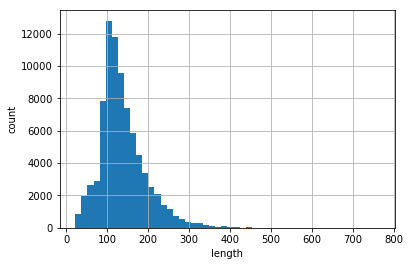

In [5]:
with open('data/train.ids.context', 'r') as f:
    result = []
    for line in f:
        result.append(len(line.split()))

pd.Series(data=result).hist(bins=50)
plt.xlabel('length')
plt.ylabel('count')

### Plot Document $\mathbf{Q}$

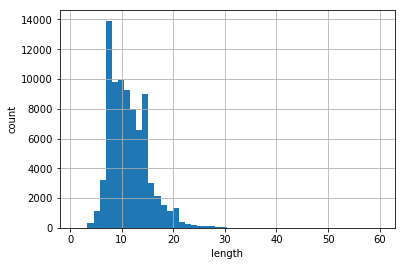

In [6]:
with open('data/train.ids.question', 'r') as f:
    result = []
    for line in f:
        result.append(len(line.split()))

pd.Series(data=result).hist(bins=50)
plt.xlabel('length')
plt.ylabel('count')

In [7]:
print (max_l_D)
print (max_l_Q)

600
60


# Encoder

In [8]:
def length(sequence):
    """calculate number of non zero values in vector
    """
    used = tf.sign(tf.reduce_max(tf.abs(sequence), axis=2))
    length = tf.reduce_sum(used, axis=1)
    length = tf.cast(length, tf.int32)
    return length

In [9]:
def encoder(question,document,embeddings,hidden_units=200):
    """build encoder
    
    question: Q
    document: D
    embeddings: GloVe
    hidden_units: hidden units
    
    return U
    """
    batch_size = tf.shape(question)[0]
    # get question and document GloVe embedding
    q_embedding = tf.nn.embedding_lookup(embeddings,question)
    d_embedding = tf.nn.embedding_lookup(embeddings,document)
    
#     print (q_embedding.shape,"=?,60,100")
#     print (d_embedding.shape,"=?,600,100")
    
    lstm_enc = tf.contrib.rnn.BasicLSTMCell(hidden_units)
    
    with tf.variable_scope('document_encoder') as scope1:
        document_states,_ = tf.nn.dynamic_rnn(cell=lstm_enc,
                                              dtype=tf.float32,
                                              inputs=d_embedding,
                                              sequence_length=length(q_embedding),
                                              time_major=False)
        
    with tf.variable_scope('question_encoder') as scope2:
        question_states,_ = tf.nn.dynamic_rnn(cell=lstm_enc,
                                              dtype=tf.float32,
                                              inputs=q_embedding,
                                              sequence_length=length(d_embedding),
                                              time_major=False)

    # perform additional MLP to encode Q
    Wq = tf.get_variable(name="Wq",
                         shape=[hidden_units,hidden_units],
                         initializer=tf.contrib.layers.xavier_initializer(),
                         dtype=tf.float32)
    Wq = tf.expand_dims(tf.ones([batch_size,1]), 1) * Wq
    bq = tf.Variable(name='bq',
                     initial_value=tf.constant(0.0,shape=[hidden_units,]),
                     dtype=tf.float32)

    print (document_states.shape,"=?,600,200")
    print (question_states.shape,"=?,60,200")
    print (Wq.shape,"=?,200,200")
    print (bq.shape,"=200,")
                    
    question_states_modified_duplicate = tf.nn.tanh(tf.matmul(question_states,Wq)+bq)
    question_states_modified = tf.transpose(question_states_modified_duplicate,perm=[0,2,1]) 
    
    print (question_states_modified.shape,"=?,200,60")
    print (question_states_modified_duplicate.shape,"=?,60,200")

    # coattention encoder
    
    l = tf.matmul(document_states,question_states_modified)
    print (l.shape,"=?,600,60")
    aq = tf.nn.softmax(l)
    ad = tf.nn.softmax(tf.transpose(l,perm=[0, 2, 1]))
    print (aq.shape,"=?,600,60")
    print (ad.shape,"=?,60,600")
    
    cq = tf.matmul(tf.transpose(aq,perm=[0,2,1]),document_states)
    print (cq.shape,"=?,60,200")
    print (question_states_modified_duplicate.shape,"=?,60,200")
    qcq = tf.concat([question_states_modified_duplicate,cq],2)
    print (qcq.shape,"=?,60,400")
    cd = (tf.matmul(tf.transpose(ad,perm=[0,2,1]),qcq))
    print (cd.shape,"=?,600,400")
    dcd = tf.concat([document_states,cd],axis=2)
    print (dcd.shape,"=?,600,600")
    
    with tf.variable_scope('coattention'):
        u_lstm_fw = tf.contrib.rnn.BasicLSTMCell(hidden_units)  #bi-lstm
        u_lstm_bw = tf.contrib.rnn.BasicLSTMCell(hidden_units)
        u_states,_ = tf.nn.bidirectional_dynamic_rnn(cell_bw=u_lstm_bw,cell_fw=u_lstm_fw,dtype=tf.float32,inputs=dcd,time_major=False,sequence_length=length(dcd))
    encoder_states = tf.concat(u_states,2) # concat [fw;bw] to make U
    print (encoder_states.shape)
    return encoder_states # U

# Decoder

In [10]:
def decoder(knowledge_reps,hidden_units = 200):
    """extract and predict i_start, i_end respectively from U
    
    knowledge_reps: coattention encoding U
    hidden_units: hidden units
    
    return: start_vector, end_vector, start_logits, end_logits
    """
    
    # randomly initialise s and e
    batch_size = tf.shape(knowledge_reps)[0]
#     print(f"batch_size = {batch_size}")
    pool = 16
    e = np.random.randint(max_l_D) + 1
    s = np.random.randint(e)
    sv = tf.tile([s],[batch_size])
    ev = tf.tile([e],[batch_size])

    # lstm cell
    lstm_dec = tf.contrib.rnn.LSTMCell(hidden_units)
    ch = lstm_dec.zero_state(batch_size,dtype=tf.float32)
    hi,ci = ch
    
    with tf.variable_scope('hmn1') as scope1:
        wd = tf.get_variable(name="wd",
                             shape=[hidden_units,5*hidden_units],
                             initializer=tf.contrib.layers.xavier_initializer(),
                             dtype=tf.float32)
        w1 = tf.get_variable(name="w1",
                             shape=[pool*hidden_units,3*hidden_units],
                             initializer=tf.contrib.layers.xavier_initializer(),
                             dtype=tf.float32)
        w2 = tf.get_variable(name="w2",
                             shape=[pool*hidden_units,hidden_units],
                             initializer=tf.contrib.layers.xavier_initializer(),
                             dtype=tf.float32)
        w3 = tf.get_variable(name="w3",
                             shape=[pool,2*hidden_units],
                             initializer=tf.contrib.layers.xavier_initializer(),
                             dtype=tf.float32)
    
    with tf.variable_scope('hmn2') as scope2:
        wd = tf.get_variable(name="wd",
                             shape=[hidden_units,5*hidden_units],
                             initializer=tf.contrib.layers.xavier_initializer(),
                             dtype=tf.float32)
        w1 = tf.get_variable(name="w1",
                             shape=[pool*hidden_units,3*hidden_units],
                             initializer=tf.contrib.layers.xavier_initializer(),
                             dtype=tf.float32)
        w2 = tf.get_variable(name="w2",
                             shape=[pool*hidden_units,hidden_units],
                             initializer=tf.contrib.layers.xavier_initializer(),
                             dtype=tf.float32)
        w3 = tf.get_variable(name="w3",
                             shape=[pool,2*hidden_units],
                             initializer=tf.contrib.layers.xavier_initializer(),
                             dtype=tf.float32)
        
    #loop 4 times to call lstm cell to predict sv, ev:
    for i in range(4):
        #concatenate u_s and u_e
        u_s = tf.gather_nd(params=knowledge_reps,indices=tf.stack([tf.range(batch_size,dtype=tf.int32),sv],axis=1))
        u_e = tf.gather_nd(params=knowledge_reps,indices=tf.stack([tf.range(batch_size,dtype=tf.int32),ev],axis=1))
        usue = tf.concat([u_s,u_e],axis=1)
        
        print (i,usue.shape,hi.shape)
        
        #calculate hi        
        with tf.variable_scope("hmn1",reuse=True) as scope1:
            sv,hmns_output = hmn(knowledge_reps,hi,u_s,u_e,hidden_units,pool)#loop over the document length times to obtain alpha t using HNM function
        with tf.variable_scope("hmn2",reuse=True) as scope2:
            ev,hmne_output = hmn(knowledge_reps,hi,u_s,u_e,hidden_units,pool)#loop over the document length times to obtain beta t using HNM function
        
        hi,ch = lstm_dec(inputs=usue,state=ch) 
        
    return sv,ev,hmns_output,hmne_output

In [11]:
def hmn(ut,hs,us,ue,hidden_units,pool=16):
    
    #calculate r
    wd = tf.get_variable(name="wd",
                         shape=[hidden_units,5*hidden_units],
                         initializer=tf.contrib.layers.xavier_initializer(),
                         dtype=tf.float32)
    x = tf.concat([hs,us,ue],axis=1)
    r = tf.nn.tanh(tf.matmul(x,tf.transpose(wd)))

    #calculate mt1
    r1 = tf.expand_dims(tf.ones([int(ut.shape[1]),1]), 1) * r
    r1 = tf.reshape(r1,[-1,hidden_units])
    ut1 = tf.reshape(ut,[-1,2*hidden_units])
    ut2 = tf.concat([ut1,r1],axis=1)
    w1 = tf.get_variable(name="w1",
                         shape=[pool*hidden_units,3*hidden_units],
                         initializer=tf.contrib.layers.xavier_initializer(),
                         dtype=tf.float32)
    b1 = tf.Variable(tf.constant(0.0,shape=[pool*hidden_units,]),dtype=tf.float32)
    x1 = tf.matmul(ut2,tf.transpose(w1))+b1
    x1 = tf.reshape(x1,[-1,pool])
    x1 = tf.reduce_max(x1,axis=1)
    mt1 = tf.reshape(x1,[-1,hidden_units])
    
    #calculate mt2
    w2 = tf.get_variable(name="w2",
                         shape=[pool*hidden_units,hidden_units],
                         initializer=tf.contrib.layers.xavier_initializer(),
                         dtype=tf.float32)
    b2 = tf.Variable(tf.constant(0.0,shape=[pool*hidden_units,]),dtype=tf.float32)
    x2 = tf.matmul(mt1,tf.transpose(w2))+b2
    x2 = tf.reshape(x2,[-1,pool])
    x2 = tf.reduce_max(x2,axis=1)
    mt2 = tf.reshape(x2,[-1,hidden_units])
    
    #max
    mt1mt2 = tf.concat([mt1,mt2],axis=1)
    w3 = tf.get_variable(name="w3",
                         shape=[pool,2*hidden_units],
                         initializer=tf.contrib.layers.xavier_initializer(),
                         dtype=tf.float32)
    b3 = tf.Variable(tf.constant(0.0,shape=[pool,]),dtype=tf.float32)
    x3 = tf.matmul(mt1mt2,tf.transpose(w3))+b3
    x3 = tf.reduce_max(x3,axis=1)
    hmnout = tf.reshape(x3,[-1,int(ut.shape[1])])

    #argmax
    maxout = tf.argmax(hmnout,axis=1)
    maxout = tf.cast(maxout,dtype=tf.int32)
    
    return maxout,hmnout

In [12]:
#read embedding file
embedding_array = np.load('data/glove.trimmed.100.npz')

In [13]:
embedding_array['glove'].shape

(115240, 100)

In [22]:
## create placeholders
tf.reset_default_graph()
hidden_units = 200
question = tf.placeholder(dtype=tf.int32,shape=[None,max_l_Q])
context = tf.placeholder(dtype=tf.int32,shape=[None,max_l_D])
answer_start = tf.placeholder(dtype=tf.int32,shape=[None])
answer_end = tf.placeholder(dtype=tf.int32,shape=[None])
embeddings = tf.constant(embedding_array['glove'],dtype=tf.float32)

encoder_states = encoder(question,context,embeddings)
print ("decoder starts")
decoder_output_start, decoder_output_end, hmns_output, hmne_output = decoder(encoder_states)

## add loss
l1 = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=answer_start,logits=hmns_output)
l2 = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=answer_end,logits=hmne_output)
loss = l1 + l2

## predictions
pred_start = tf.argmax(hmns_output, 1)
pred_end = tf.argmax(hmne_output, 1)

## add optimizer
train_op = tf.train.AdamOptimizer(0.001).minimize(loss)

(?, 600, 200) =?,600,200
(?, 60, 200) =?,60,200
(?, 200, 200) =?,200,200
(200,) =200,
(?, 200, 60) =?,200,60
(?, 60, 200) =?,60,200
(?, 600, 60) =?,600,60
(?, 600, 60) =?,600,60
(?, 60, 600) =?,60,600
(?, 60, 200) =?,60,200
(?, 60, 200) =?,60,200
(?, 60, 400) =?,60,400
(?, 600, 400) =?,600,400
(?, 600, 600) =?,600,600
(?, 600, 400)
decoder starts
0 (?, 800) (?, 200)
1 (?, 800) (?, 200)
2 (?, 800) (?, 200)
3 (?, 800) (?, 200)


# Evaluate

## Define Exact Matching (EM) and F1 Score

In [15]:
from collections import Counter
def evaluate(context, predict_start, predict_end, answer_start, answer_end):
    f1_scores = []
    em_scores = []
    for i, vector in enumerate(context):
        prediction_tokens = vector[predict_start[i]:predict_end[i]+1]
        ground_truth_tokens = vector[answer_start[i]:answer_end[i]+1]
        common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
        num_same = sum(common.values())
        if num_same == 0:
            f1_scores.append(0)
            continue
        precision = 1.0 * num_same / len(prediction_tokens)
        recall = 1.0 * num_same / len(ground_truth_tokens)
        f1 = (2 * precision * recall) / (precision + recall)
        em = set(prediction_tokens) == set(ground_truth_tokens)
        f1_scores.append(f1)
        em_scores.append(em)
    return np.mean(f1_scores), np.mean(em_scores)

evaluate(D_data, A_start_data, A_end_data,A_start_data, A_end_data )

(0.99927521098731009, 1.0)

# Model Fit

In [16]:
len(D_data) / 128

635.9609375

In [23]:
#initialise variables and train
init = tf.global_variables_initializer()

In [ ]:
# quick validation, use last batch record in training set

logger = Logger("./logs")

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(init)
    batch_size = 128
    
    for epocs in range(100):
        counter = 0
        for steps in range(636):
            Q_batch = np.array(Q_data[counter:(counter+batch_size)])
            D_batch = np.array(D_data[counter:(counter+batch_size)])
            A_start_batch = np.array(A_start_data[counter:(counter+batch_size)])
            A_end_batch = np.array(A_end_data[counter:(counter+batch_size)])
            
            # get prediction, evaluate score outside tensorflow (for simplicity)
            _, loss_batch, pred_start_batch, pred_end_batch = sess.run([train_op, loss, pred_start, pred_end], 
                                                           feed_dict = {question : Q_batch, context : D_batch, answer_start : A_start_batch, answer_end : A_end_batch})
            f1, em = evaluate(D_batch, pred_start_batch,pred_end_batch, A_start_batch, A_end_batch)
            print ("-" * 20)
            print ("step = ", steps)
            print ("F1 Score = ", f1)
            print ("EM score = ", em)
            print ("loss_train = ", np.mean(loss_batch))
            
            # use PyTorch tensorboard logger, to log scalar outside of tensorflow
            logger.scalar_summary('f1_train', f1, steps + epocs * 636)
            logger.scalar_summary('em_train', em, steps + epocs * 636)
            logger.scalar_summary('loss_train', np.mean(loss_batch), steps + epocs * 636)
                
            if steps % 100 == 0:
                Q_val = np.array(Q_data[-batch_size:])
                D_val = np.array(D_data[-batch_size:])
                A_start = np.array(A_start_data[-batch_size:])
                A_end = np.array(A_end_data[-batch_size:])
                loss_val, pred_start_val, pred_end_val = sess.run([loss,pred_start,pred_end], feed_dict = {question : Q_val, context : D_val, answer_start : A_start, answer_end : A_end})
                f1_val, em_val = evaluate(D_val,pred_start_val,pred_end_val, A_start,A_end)
                print ("="*20)
                print ("Validation Step = ", steps)
                print ("Validation F1 Score = ", f1_val)
                print ("Validation EM Score = ", em_val)
                print ("Validation loss = ", np.mean(loss_val))
                
                # log validation
                logger.scalar_summary('f1_val', f1_val, steps + epocs * 636)
                logger.scalar_summary('em_val', em_val, steps + epocs * 636)
                logger.scalar_summary('loss_val', np.mean(loss_val), steps + epocs * 636)               
                
            counter = counter + batch_size

--------------------
step =  0
F1 Score =  0.0257043899373
EM score =  0.0
loss_train =  12.7627
Validation Step =  0
Validation F1 Score =  0.0116003203469
Validation EM Score =  0.0
Validation loss =  12.5466
--------------------
step =  1
F1 Score =  0.0218750360715
EM score =  0.0
loss_train =  12.5125
--------------------
step =  2
F1 Score =  0.0115918803419
EM score =  0.0
loss_train =  11.616
--------------------
step =  3
F1 Score =  0.0303013392857
EM score =  0.0
loss_train =  12.6719
--------------------
step =  4
F1 Score =  0.0277937043768
EM score =  0.0
loss_train =  11.4401
--------------------
step =  5
F1 Score =  0.0324644134497
EM score =  0.0
loss_train =  11.4763
--------------------
step =  6
F1 Score =  0.0235225558755
EM score =  0.0
loss_train =  11.6627
--------------------
step =  7
F1 Score =  0.0267647372981
EM score =  0.0
loss_train =  11.8135
--------------------
step =  8
F1 Score =  0.0251674107143
EM score =  0.142857142857
loss_train =  11.2959
---

--------------------
step =  78
F1 Score =  0.072608346667
EM score =  0.030303030303
loss_train =  9.25807
--------------------
step =  79
F1 Score =  0.049110820087
EM score =  0.037037037037
loss_train =  9.24102
--------------------
step =  80
F1 Score =  0.0514127241986
EM score =  0.0
loss_train =  9.38033
--------------------
step =  81
F1 Score =  0.0685310251489
EM score =  0.181818181818
loss_train =  9.3267
--------------------
step =  82
F1 Score =  0.0581615191408
EM score =  0.0689655172414
loss_train =  9.26033
--------------------
step =  83
F1 Score =  0.0523402595813
EM score =  0.0384615384615
loss_train =  9.39788
--------------------
step =  84
F1 Score =  0.0282705190139
EM score =  0.0
loss_train =  9.46683
--------------------
step =  85
F1 Score =  0.0501563245393
EM score =  0.0
loss_train =  9.34104
--------------------
step =  86
F1 Score =  0.0374557299769
EM score =  0.0
loss_train =  9.80237
--------------------
step =  87
F1 Score =  0.0563014372335
EM s

--------------------
step =  153
F1 Score =  0.0844819667398
EM score =  0.222222222222
loss_train =  9.82338
--------------------
step =  154
F1 Score =  0.0588327223321
EM score =  0.0689655172414
loss_train =  9.20692
--------------------
step =  155
F1 Score =  0.0742896923247
EM score =  0.103448275862
loss_train =  9.08432
--------------------
step =  156
F1 Score =  0.0591716585715
EM score =  0.0285714285714
loss_train =  9.45761
--------------------
step =  157
F1 Score =  0.100786859214
EM score =  0.166666666667
loss_train =  9.28324
--------------------
step =  158
F1 Score =  0.0685941327564
EM score =  0.0740740740741
loss_train =  9.27672
--------------------
step =  159
F1 Score =  0.0768353421904
EM score =  0.148148148148
loss_train =  9.05223
--------------------
step =  160
F1 Score =  0.0560842977306
EM score =  0.0344827586207
loss_train =  9.56123
--------------------
step =  161
F1 Score =  0.0854476157846
EM score =  0.259259259259
loss_train =  9.27338


# Training Dynamic: see tensorboard